# 0.0. - SUMMARY
This project aims to analyze and model retail store sales data using various data science techniques and machine learning algorithms. The dataset includes information about different stores and their daily sales performance over a certain period.

## 0.1. - Imports:
In this section, all the necessary libraries and modules are imported. These libraries provide the required functionality for various data manipulation, visualization, and modeling tasks.

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import datetime
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import json

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib.gridspec   import GridSpec
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.2. - Helper Functions:
This section contains several helper functions that will be used throughout the project to perform various tasks such as data pre-processing, error calculation and cross-validation. These functions help improve code organization and reuse.

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()


## 0.3. - Loading Data:
In this section, the code is focused on loading the data into pandas DataFrames.

In [3]:
df_sales_raw = pd.read_csv( 'Data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'Data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. - STEP ONE - DATA DRESCRIPTION
In this section, the first step of the analysis is carried out, which consists of the description of the data. Here, data characteristics will be explored, such as descriptive statistics, variable types, missing values, among other relevant information about the data set.

In [4]:
## 0.4. - COPY DATA
# GOOD PRATICE: CREATING A COPY
# Making a copy of the DataFrame is a good practice as it helps avoid unintentional modifications to the original data during data exploration, preprocessing, and modeling.

# Create a copy of the DataFrame df_raw and store it in df1.
df1 = df_raw.copy()

## 1.1. - Rename Columns:
In this section, the columns of the dataset will be renamed according to the analysis requirements. The renaming technique used here is "snake_case," which converts all column names to lowercase and separates them by underscores.

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. - Data Dimensions:
In this section, the dimensions of the dataset will be presented, that is, the number of rows (samples) and columns (attributes). This step is important for us to have an overview of the amount of information available and to understand the size of the data set we are working with.

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. - Data Types:
In this section, we'll explore the data types of each column in the DataFrame df1. Understanding data types is crucial for data manipulation, analysis, and pre-processing. Different data types represent different types of information, such as numeric values, strings, dates, or categorical variables.

By examining data types, we can identify any inconsistencies or potential issues in the dataset, as well as determine which columns may require type conversion or additional data processing.

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. - Check and Handle Missing Values (NAs):
In this section, we check for missing values ​​in the DataFrame df1 and handle them accordingly. We will apply appropriate strategies to fill in the missing data, in line with Rossmann's business model, to ensure data consistency and integrity for further analysis and modeling.

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [9]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
494319,45,1,2014-04-14,8205,534,1,1,0,1,d,a,9710.0,2.0,2014.0,0,NaN,NaN,NaN


In [10]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5. - Change Data Types:
In this section, we will convert the data types of certain columns to more appropriate formats, optimizing memory usage, and ensuring consistency in data representation.

In [12]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.6. Descriptive Statistical:
In this section, we will perform descriptive statistical analysis on the dataset to gain insights into the data's distribution and central tendencies.

In [13]:
num_attributes = df1.select_dtypes( include=['int64', 'float64', 'int32'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]', 'int32'] )

### 1.6.1. Numerical Attributes:
In this section, we will perform descriptive statistical analysis on the numerical attributes of the dataset. The goal is to gain insights into the distribution, central tendency, and dispersion of these numerical features.

In [14]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='competition_distance'>

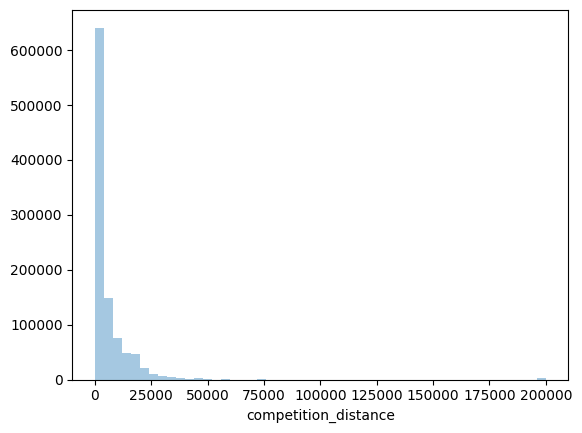

In [15]:
sns.distplot( df1['competition_distance'], kde=False )

### 1.6.2. Categorical Attributes:
In this section, we will analyze the categorical attributes present in dataframe df1. These attributes are non-numeric variables that represent different categories or groups. We will do an exploratory analysis of these attributes to understand their distribution and frequency.

In [16]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

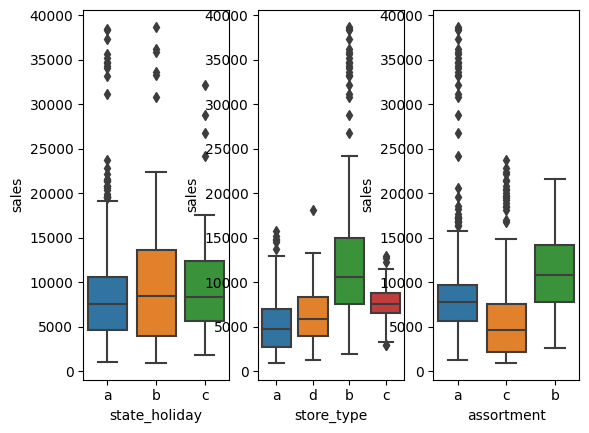

In [17]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0. - STEP TWO - FEATURE ENGINEERING
In this step, we will perform attribute engineering, which involves creating and transforming attributes in order to improve data quality and provide more relevant information for the sales forecast model.

In [18]:
df2 = df1.copy()

## 2.1. - Mental Map of Hypotheses:

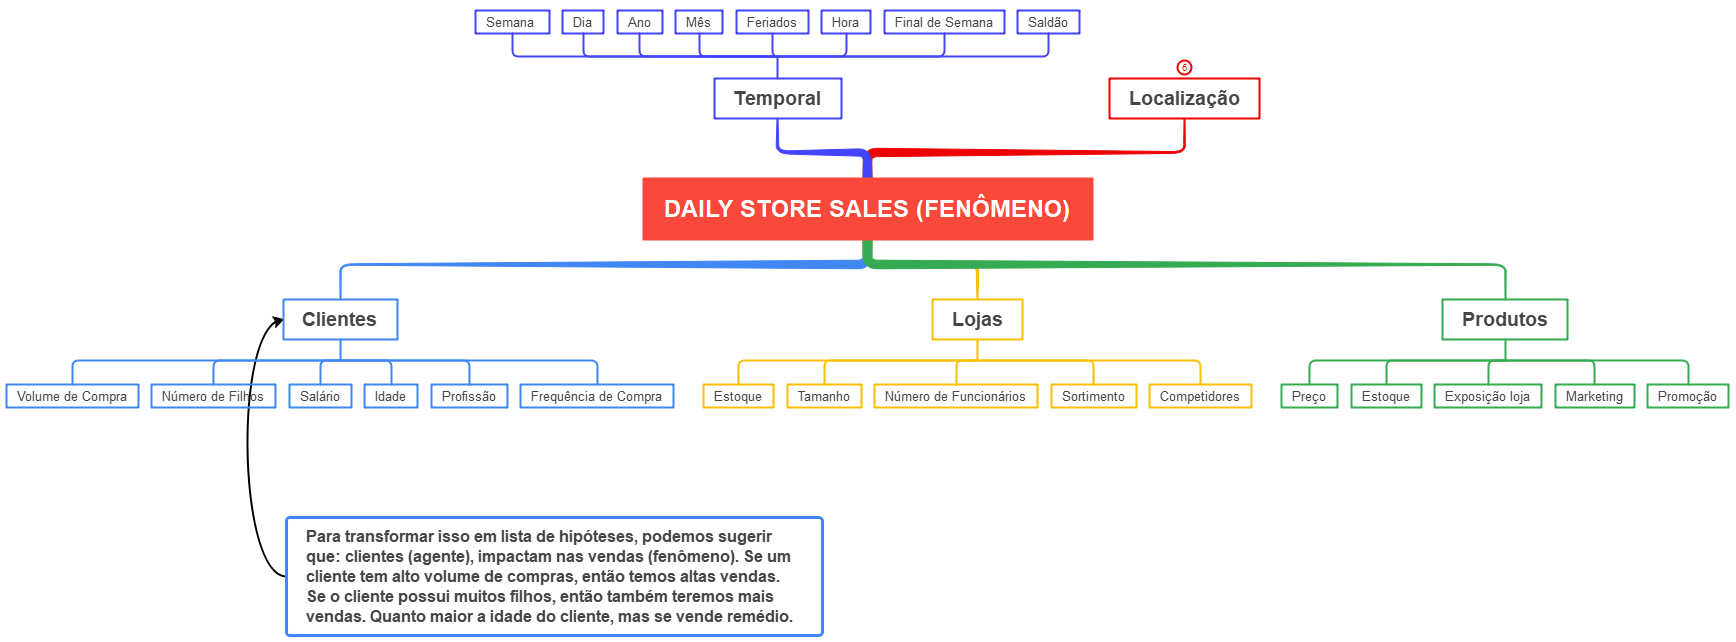

In [19]:
Image('img/MindMapHyphoteses.png')

## 2.2. - Formulation of Hypotheses:
In this section, we will formulate hypotheses that will help guide our analyzes and decision-making throughout the project. Hypotheses are assumptions that we can test using available data. They are essential to guide our exploration of the data and help us find patterns and insights relevant to the problem at hand.

### 2.1.1. - Hyphoteses related to the Stores:
1. Stores with more employees should sell more.
2. Stores with more inventory should sell more.
3. Bigger stores should sell more.
4. Stores with a larger assortment should sell more.
5. Stores with closer competitors should sell less.
6. Stores with longer competitors should sell more.

### 2.1.2. - Hypotheses related to the Products:
1. Stores that invest more in marketing should sell more.
2. Stores that display more products should sell more.
3. Stores that have lower prices should sell more.
4. Stores that have promotions active for a longer time should sell more.
5. Stores with more aggressive promotions (bigger discounts) should sell more.
6. Stores with more consecutive promotions should sell more.

### 2.1.3. - Hypotheses related to Time:
1. Stores should sell more after the 10th of every month.
2. Stores should sell less on weekends.
3. Stores should sell less during school holidays.
4. Stores open over the Christmas holiday should sell more.
5. Stores should sell more over the years.
6. Stores should sell more in the second half of the year.

## 2.3. - Final List of Hypotheses:

**Hyphoteses related to the Stores:**
1. Stores with a larger assortment should sell more.
2. Stores with closer competitors should sell less.
3. Stores with longer competitors should sell more.

**Hypotheses related to the Products:**
4. Stores that have promotions active for a longer time should sell more.
5. Stores with more aggressive promotions (bigger discounts) should sell more.
6. Stores with more consecutive promotions should sell more.

**Hypotheses related to Time:**
7. Stores should sell more after the 10th of every month.
8. Stores should sell less on weekends.
9. Stores should sell less during school holidays.
10. Stores open over the Christmas holiday should sell more.
11. Stores should sell more over the years.
12. Stores should sell more in the second half of the year.

## 2.4. - Practical Feature Engineering:
In this section, we will perform feature engineering on the DataFrame df2. Feature engineering involves creating new features or transforming existing ones to provide better inputs to machine learning models and improve model performance.

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0. - STEP THREE - VARIABLE FILTERING
In this step, we will filter the variables to select only the relevant features for our analysis and modeling. This process aims to reduce dimensionality and focus on the most important attributes that can significantly impact sales prediction.

In [21]:
# GOOD PRATICE: CREATING A COPY FOR STEP THREE

# Create a copy of the DataFrame df2 it in df3.
df3 = df2.copy()

## 3.1. - Line filtering:
We will remove data from stores that are closed since they would not have any sales.

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. - Column selection:

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0. - STEP FOUR - EXPLORATORY DATA ANALYSIS (EDA)
Exploratory Data Analysis (EDA) is a critical step in any data science and predictive modeling project. In this phase, we will explore and examine the dataset in more detail to gain insights, understand patterns, identify trends and anomalies, and prepare the data for predictive modeling.

In [24]:
# GOOD PRATICE: CREATING A COPY FOR STEP FOUR

# Create a copy of the DataFrame df3 it in df4.
df4 = df3.copy()

## 4.1. - Univariate Analysis:
In this section, we will perform univariate analysis on the dataset. Univariate analysis involves examining each variable individually to understand its distribution, central tendency, dispersion, and any potential outliers. This analysis helps us gain insights into the characteristics of each variable and identify any data issues that may need to be addressed.

### 4.1.1. - Reponse Variable: Sales Distribution
In this subsection, we will focus on the response variable, which is the target variable we aim to predict or explain. In our case, the response variable is the 'sales' column, representing the daily sales for each store.

<Axes: xlabel='sales'>

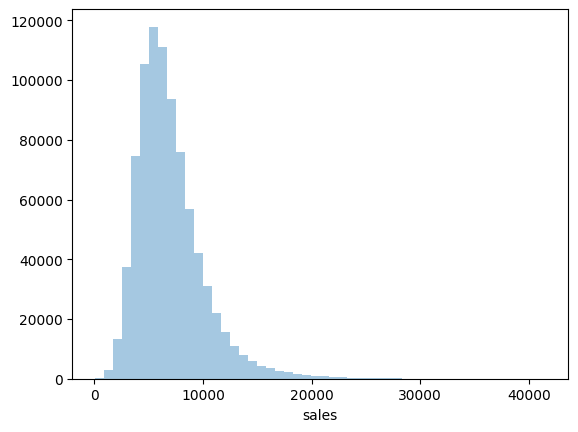

In [25]:
sns.distplot( df4['sales'], kde=False  )

### 4.1.2. - Numerical Variable:
In this section, we will perform a univariate analysis of numeric variables. Numerical variables are those that represent quantitative values, such as sales, number of customers, close competitors, among others.

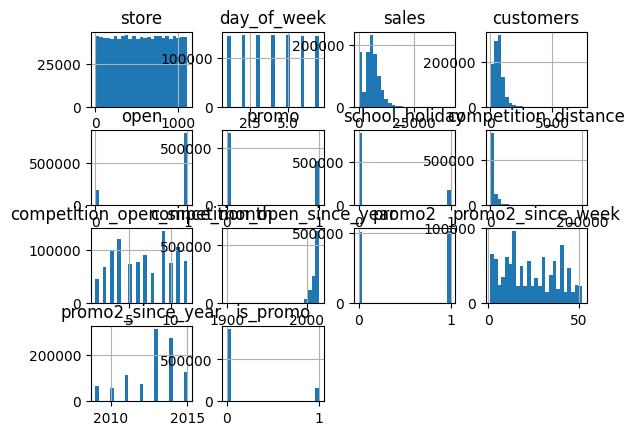

In [26]:
num_attributes.hist( bins=25 );

### 4.1.3. - Categorical Variable:
In this section, we will explore the categorical variables in our dataset. Categorical variables are non-numeric and represent different categories or groups.

<Axes: xlabel='sales', ylabel='Density'>

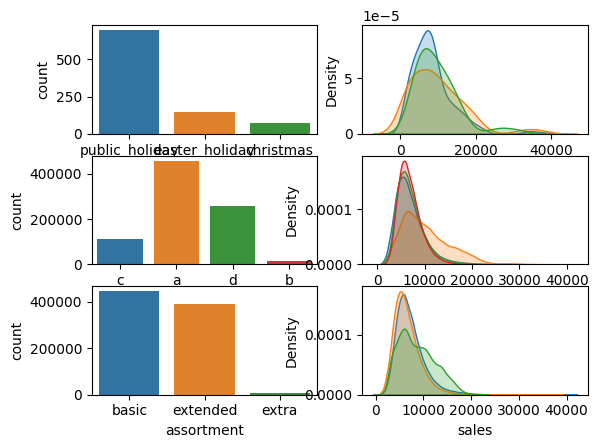

In [27]:
#state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x = a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x = df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x= df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2. - Bivariate Analysis:
In this section, we will perform a bivariate analysis, exploring the relationship between two variables. Let's investigate how numerical and categorical variables behave together and how they can influence sales.

### 4.2.2. Stores with a larger assortment should sell more:
Analysis has shown this to be a false claim. This goes against common sense. The assortment variable explains two types of behavior, so it seems to be interesting for the model.

<Axes: xlabel='year_week'>

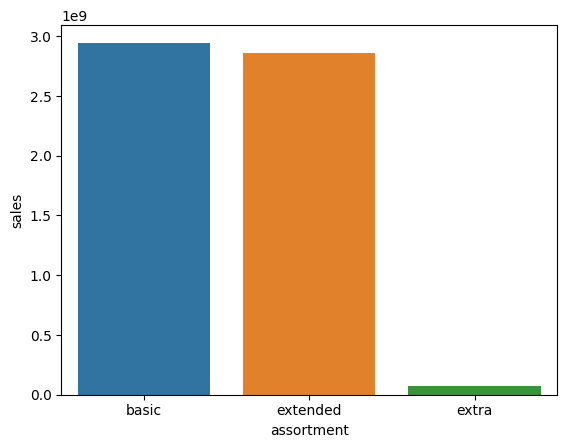

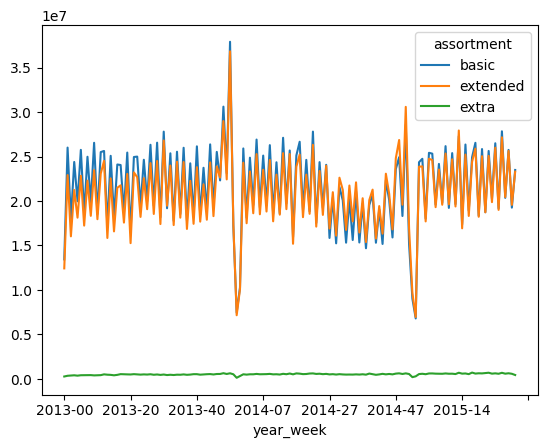

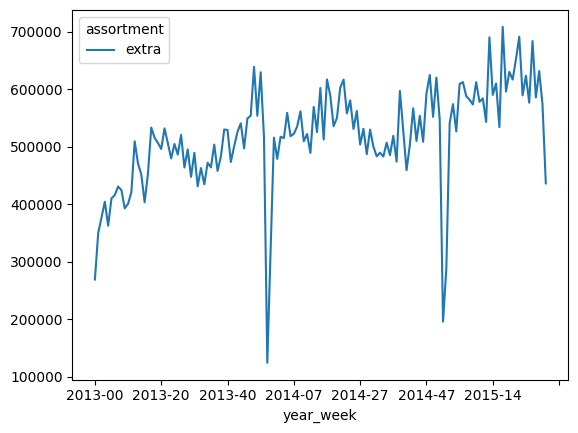

In [28]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### 4.2.1. Stores with closer competitors should sell less:
Analysis has shown this to be a false claim. This goes against common sense. However, it has a weak correlation with the model.

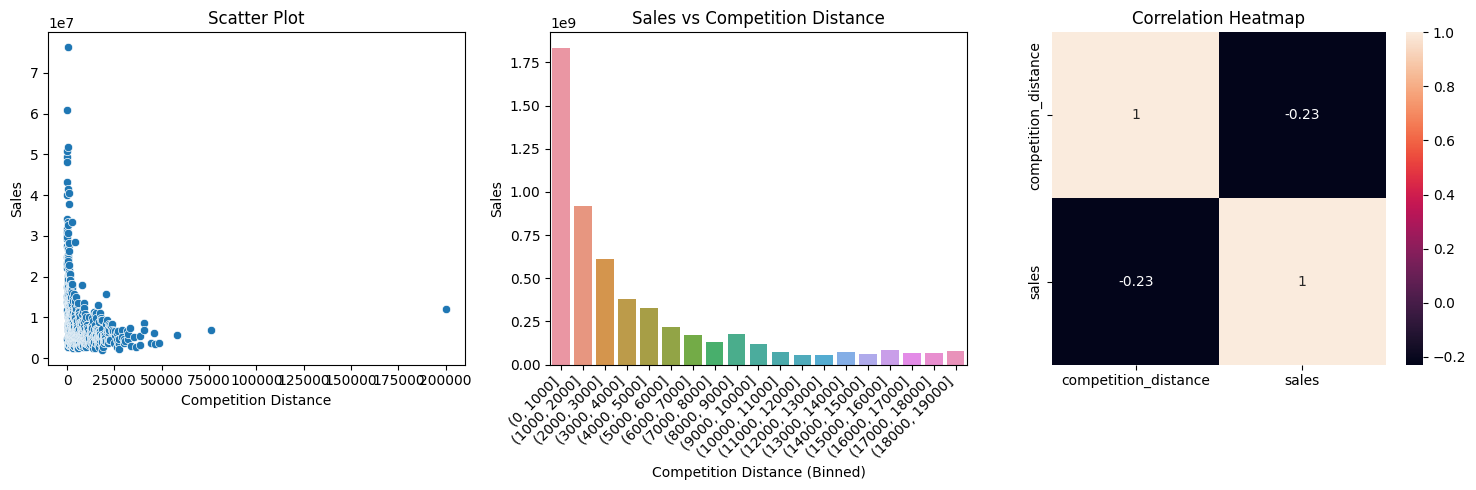

In [29]:
# Grouping the data by competition distance and calculating the sum of sales for each distance
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# Creating a figure with a size of 15x5
plt.figure(figsize=(15, 5))

# Subplot 1: Scatter plot to visualize the relationship between competition distance and sales
plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)
plt.xlabel('Competition Distance')
plt.ylabel('Sales')
plt.title('Scatter Plot')

# Subplot 2: Bar plot showing sales distribution across competition distance intervals
plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Competition Distance (Binned)')
plt.ylabel('Sales')
plt.title('Sales vs Competition Distance')

# Subplot 3: Heatmap showing the correlation between competition distance and sales
plt.subplot(1, 3, 3)
correlation = aux1[['competition_distance', 'sales']].corr(method='pearson')
sns.heatmap(correlation, annot=True)
plt.title('Correlation Heatmap')

# Adjusting the layout of subplots to prevent overlapping
plt.tight_layout()

# Displaying the plots
plt.show()

### 4.2.3. Stores with competitors for a longer time should sell more.
Analysis has shown this to be a false claim. This goes against common sense. However, it has a weak correlation with the model.

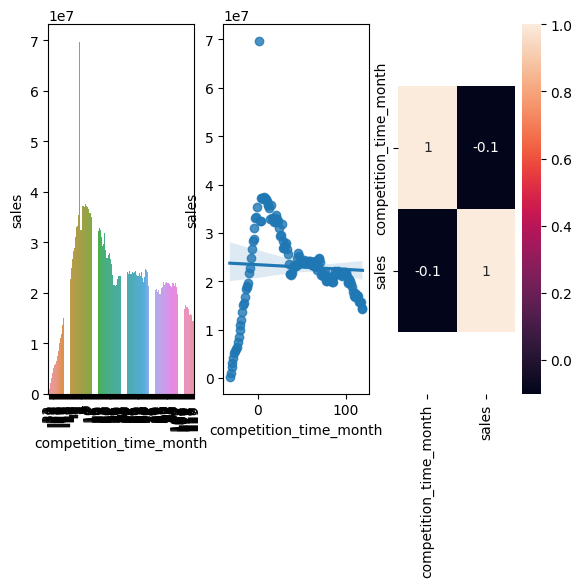

In [30]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### 4.2.4. Stores with promotions active for longer should sell more.
Analysis has shown this to be a false claim. This goes against common sense. However, it has a weak correlation with the model.

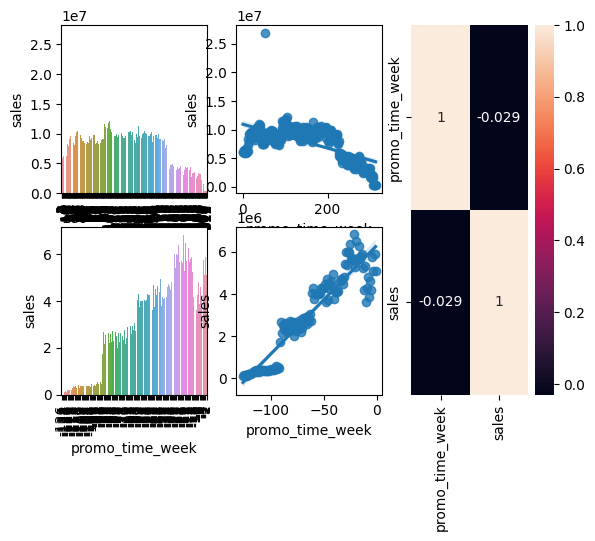

In [31]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.5. Stores with more days on sale should sell more.
Will be validated in the next CRISP cycle as it needs to create new columns.

### 4.2.6. Stores with more consecutive promotions should sell more.
Analysis has shown this to be a false claim. This goes against common sense. However, only a part will be relevant to the model.

In [32]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


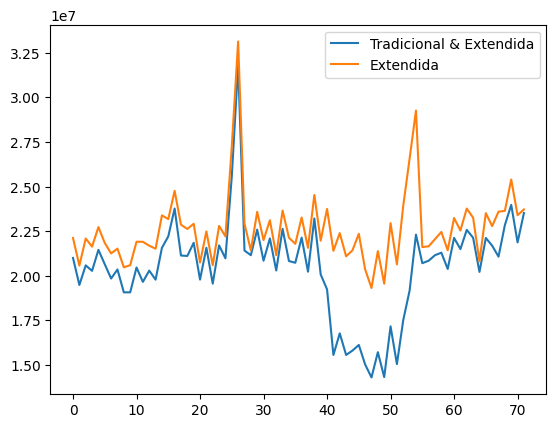

In [33]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### 4.2.7. Stores open during the Christmas holiday should sell more.
Analysis has shown this to be a false claim. This goes against common sense. However, the business team must already follow this. It is interesting for the model.
"Christmas holiday" (state_holiday == 'christmas') always sold less over the years compared to other holidays.

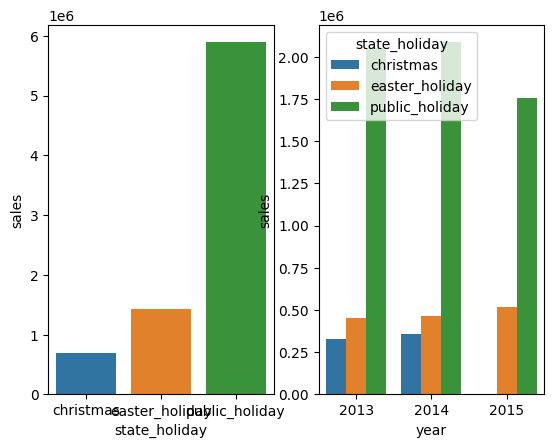

In [34]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### 4.2.8. Stores should sell more over the years.
Analysis has shown this to be a false claim. This goes against common sense. However, the business team must already follow this. It is interesting for the model.

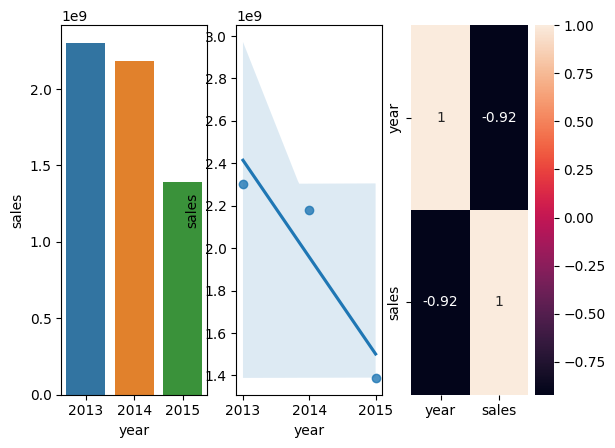

In [35]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.9. Stores should sell more in the second half of the year.
Analysis has shown this to be a false claim. However, the business team must already follow this. It is interesting for the model.

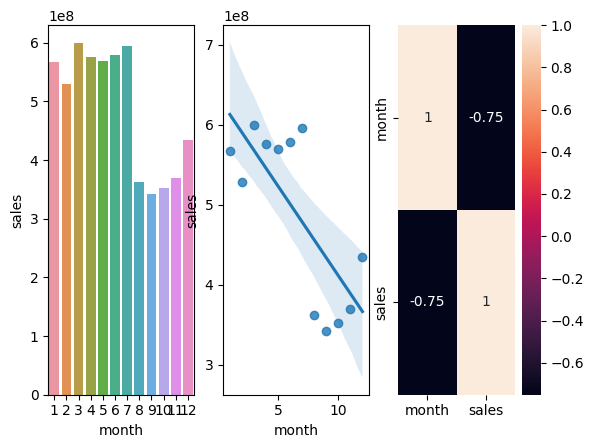

In [36]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.10. Stores should sell more after the 10th of each month.
Analysis has shown this to be a true claim. However, account must be taken of the day count. Metric that may be relevant to the model.

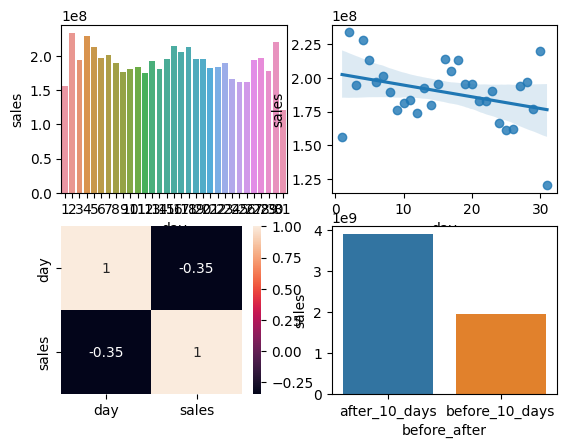

In [37]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

### 4.2.11. Stores should sell less on weekends.
Analysis has shown this to be a true claim. However, the business team must already follow this. It concerns the seasonality of the business. It is interesting for the model.

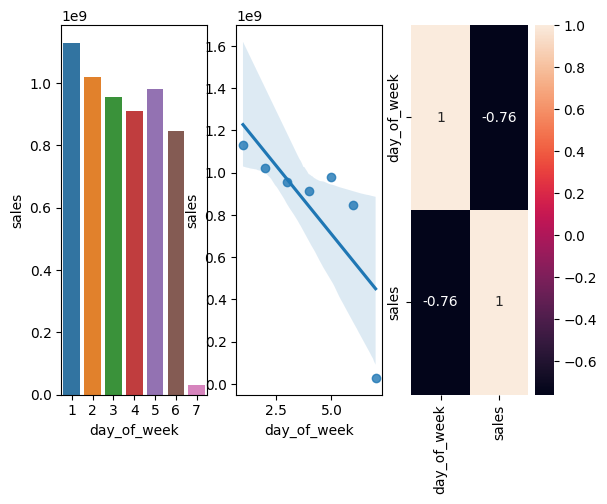

In [38]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### 4.2.12. Stores should sell less during school holidays.
Analysis has shown this to be a true claim, except in July and August. It is interesting for the model, to learn that during these months there will be a change in behavior

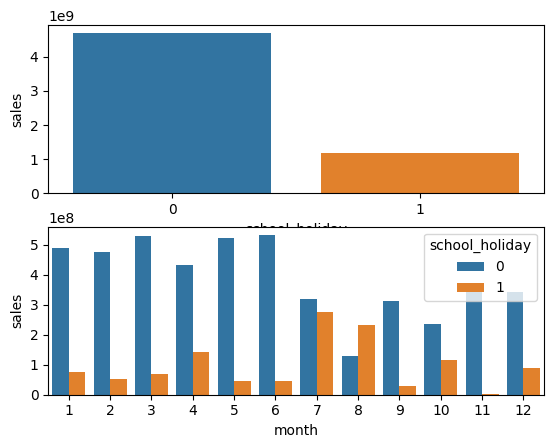

In [39]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

### 4.2.13. Summary of hypotheses:

In [40]:
from tabulate import tabulate

In [41]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. - Multivariate analysis:

### 4.3.1. - Numerical Attributes:

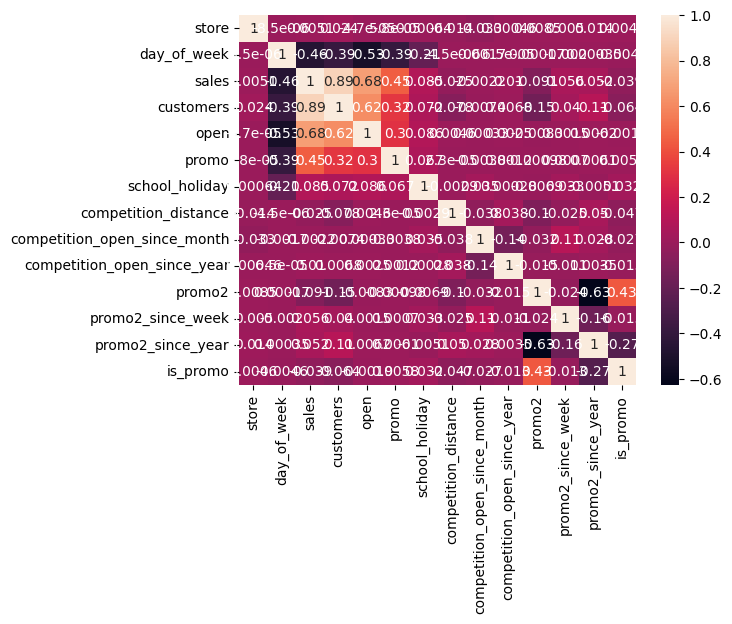

In [42]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2. - Categorical Attributes:

In [43]:
# # only categorical data
# a = df4.select_dtypes( include='object' )

# # Calculate cramer V
# a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
# a2 = cramer_v( a['state_holiday'], a['store_type'] )
# a3 = cramer_v( a['state_holiday'], a['assortment'] )

# a4 = cramer_v( a['store_type'], a['state_holiday'] )
# a5 = cramer_v( a['store_type'], a['store_type'] )
# a6 = cramer_v( a['store_type'], a['assortment'] )

# a7 = cramer_v( a['assortment'], a['state_holiday'] )
# a8 = cramer_v( a['assortment'], a['store_type'] )
# a9 = cramer_v( a['assortment'], a['assortment'] )

# # Final dataset
# d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
#                'store_type': [a4, a5, a6],
#                'assortment': [a7, a8, a9]  })
# d = d.set_index( d.columns )

# sns.heatmap( d, annot=True )

# 5.0. - STEP FIVE - DATA PREPARATION
In this step, we will focus on preparing the data for training machine learning models. Data preparation is a crucial step in the model building process, as it ensures that the data is in a suitable format and contains the relevant information for learning the algorithm.

In [44]:
# GOOD PRATICE: CREATING A COPY FOR STEP FIVE

# Create a copy of the DataFrame df4 it in df5.
df5 = df4.copy()

## 5.1. - Normalization:
Normalization is an important data pre-processing technique that aims to place all variables on a common scale, so that they have comparable values ​​and do not dominate each other during model training. This step is especially useful when we have variables with different scales or when we apply scale-sensitive algorithms to the data, such as gradient-based techniques.
There is no normalization to be done on this dataset

## 5.2. - Rescaling:
Rescaling, is another important data pre-processing step. Unlike normalization, scaling aims to place all variables on a specific scale, usually to facilitate interpretation or improve the performance of algorithms that are sensitive to the scale of the data.

In [45]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 5.3. - Transformation:
Data transformation is an important step in data pre-processing, which aims to modify the distribution of variables to make them more suitable for statistical analysis or to improve the performance of machine learning algorithms.

### 5.3.1. - Encoding:
Variable coding is an important data pre-processing step when dealing with categorical variables in our dataset. Categorical variables are those that represent different categories or classes, but do not have a natural order or hierarchy among them.

In [46]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. - Response Variable Transformation:
Transforming the response variable is an important step in data preparation when we are dealing with regression problems, where the response variable is continuous and we are looking to predict a numerical value. In this context, it is common that the distribution of the response variable is not ideal for applying certain regression algorithms

In [47]:
# Applying the logarithmic transformation to the 'sales' column
df5['sales'] = np.log1p(df5['sales'])

# Explanation:
# The np.log1p() function calculates the natural logarithm of the input array 'sales' plus one.
# This transformation is used to address the positive skewness in the 'sales' data, making it more suitable for certain regression models.
# It helps to compress the scale of the data and reduce the impact of extreme high values, leading to a more symmetric distribution.
# The use of np.log1p() instead of np.log() is preferred to handle cases where the data may contain zero or negative values.
# After the transformation, the 'sales' column in the DataFrame df5 contains the log-transformed values.

### 5.3.3. Nature Transformation:
Nature transformation involves transforming variables based on their underlying nature or domain knowledge. This step is particularly useful when dealing with cyclic or periodic data, such as time series or circular data.

In [48]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day 
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0. - STEP SIX - SELECTION OF VARIABLES
In this step, we will perform feature selection to choose the most relevant variables that will be used in our machine learning model. The goal is to remove any irrelevant or redundant features to improve the model's performance and reduce the risk of overfitting.

In [49]:
# GOOD PRATICE: CREATING A COPY FOR STEP SIX

# Create a copy of the DataFrame df5 it in df6.
df6 = df5.copy()

## 6.1. - Split dataframe into training and test dataset:
In this step, we will split the DataFrame into training and test datasets. The training dataset will be used to train the machine learning model, while the test dataset will be used to evaluate its performance.

In [50]:
# Deleting derived columns
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [51]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. - Boruta as Feature Selector:
In this section, the Boruta algorithm is used as a feature selector. 
The Boruta algorithm is a feature selection method based on the Random Forest algorithm. It is used to identify the most important features in a dataset by comparing the importance of each feature with the importance of randomly created shadow features.

Ps.:Given the boruta selection time, it will be presented - as commented code - two alternatives.

Pss.: Due to Boruta's high execution time, after running it once, we will save its result to use in the future without having to run it again.

In [52]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

In [53]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [54]:
# # Alternative one to Boruta - Random Forest Selector

# # Define DataFrame X_train and y_train
# # Training and test dataset for Random Forest feature importance
# X_train_n = X_train.drop(['date', 'sales'], axis=1)
# y_train_n = y_train.values.ravel()

# # Define the Random Forest model
# # Create a Random Forest Regressor model with 100 estimators, using all available CPU cores, and a random seed of 42
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# # Train the model on the training dataset
# rf.fit(X_train_n, y_train_n)

# # Get the feature importances from the trained Random Forest model
# feature_importance = rf.feature_importances_

# # Create a DataFrame with the features and their importances
# feature_importance_df = pd.DataFrame({'Feature': X_train_n.columns, 'Importance': feature_importance})

# # Sort the DataFrame by importance in descending order
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Display the top 10 most important features
# print(feature_importance_df.head(10))

In [55]:
# # Alternative two to Boruta: Recursive Feature Elimination (RFE) with Random Forest

# # Import required libraries
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import RandomForestClassifier

# # Select the feature columns
# # selected_features = df6.columns.tolist() # Uncomment this line if you want to consider all columns as features
# selected_features = ['feature1', 'feature2', 'feature3', ...]  # Specify the features you want to consider

# # Create the model for feature selection
# model = RandomForestClassifier()

# # Perform Recursive Feature Elimination (RFE) using the selected features and the target variable 'sales'
# X = df6[selected_features]
# y = df6['sales']
# rfe = RFE(estimator=model)  # You can also set the 'n_features_to_select' parameter to define the desired number of selected features
# X_selected = rfe.fit_transform(X, y)

# # Check which features were selected
# selected_feature_names = X.columns[rfe.support_]
# print("Selected Features:", selected_feature_names)

## 6.3. - Manual Feature Selection Boruta:
The manual selection of features is the selection of the most important columns, defined by boruta, so we don't need to run it again

In [56]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. - STEP SEVEN - TRAINING OF MACHINE LEARNING ALGORITHMS
In this step we will train the machine learning algorithms

In [57]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. - Average Model:
The average model is a simple and intuitive approach to make predictions. It involves calculating the average value of the target variable (in this case, sales) from the training data and using this average as the predicted value for all instances in the test data.

In [58]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. - Linear Regression Model:
In this section, we will create and evaluate a Linear Regression model using the selected features from the Boruta feature selection process.

In [59]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. - Linear Regression - Cross Validation:
In this section, we will perform cross-validation for the Linear Regressor model. 

Ps.: Cross-validation is a technique used to assess the model's performance by dividing the data into multiple subsets (folds) and training and testing the model on different combinations of these subsets. This helps to obtain a more robust estimate of the model's performance and reduces the risk of overfitting.

In [60]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. - Regularized Linear Regression Model - Lasso:
In this section, we will create and evaluate a Regularized Linear Regression model using the selected features from the Boruta feature selection process.

In [61]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. - Lasso Regression - Cross Validation:
In this section, we will perform cross-validation for the Lasso Regressor model. 

In [62]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. - Random Forest Regressor Model:
In this section, we will implement the Random Forest Regressor model. Random Forest is an ensemble learning method that combines multiple decision trees to create a more robust and accurate model.

In [63]:
# # model
# rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# # prediction
# yhat_rf = rf.predict( x_test )

# # performance
# rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
# rf_result

### 7.4.1. Random Forest Regressor - Cross Validation:
In this section, we will perform cross-validation for the Random Forest Regressor model. 

In [64]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv

## 7.5. - Model XGBoost Regressor:
In this section, we will build a regression model using XGBoost, a popular gradient boosting algorithm that is known for its high performance and flexibility. XGBoost is an ensemble learning method that combines the predictions of multiple weak learners (typically decision trees) to create a more powerful and accurate model.

In [65]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.667628,0.949516,7330.817866


### 7.5.1. XGBoost Regressor - Cross Validation:
In this section, we will perform cross-validation for the XGBoost Regressor.

In [66]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.98 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


## 7.6. - Compare Model's Performance:
In this section, we will compare the performance of different models that we have built so far. We will evaluate each model using the Root Mean Squared Error (RMSE) metric, which measures the average magnitude of the errors in the predictions. Lower RMSE values indicate better performance. MAE and MAPE.

In [67]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.667628,0.949516,7330.817866


## 7.7. - Comparative Cross Validation Model's Performance - Real Performance:
In this section, we will perform a cross-validation of the models to obtain a more reliable estimate of their performance. Cross-validation involves splitting the training dataset into multiple subsets (folds), training the model on some of these folds, and testing it on the remaining folds. This process is repeated several times, and the performance metrics are averaged over all folds to get a more accurate evaluation of the model's performance.

In [68]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7047.98 +/- 587.65,0.95 +/- 0.0,7714.03 +/- 688.72


# 8.0. - STEP EIGHT - FINE TUNING
In this step, we focus on improving the models' performance by fine-tuning their hyperparameters. This process involves searching for the best combination of hyperparameters that optimize the models' performance on the training data. Fine-tuning is essential to achieve better accuracy and generalization on unseen data.

Ps.: For the first CRISP cycle of this project, we will use Random Search for the XGBoost model. In a second cycle we will implement the same technique, but for the Random Forest Regressor model

## 8.1. - Random Search:
Random Search, we will perform hyperparameter tuning using the Random Search technique. Random Search is a hyperparameter optimization method that randomly samples hyperparameter combinations from a predefined search space. It is an efficient way to explore a wide range of hyperparameter values without trying all possible combinations.

### 8.1.1. - Random Search For XGBoost Model:
In this step, we will save the result so that it is not necessary to run the code again.

In [69]:
#param = {
#    'n_estimators': [1500, 1700, 2500, 3000, 3500],
#    'eta': [0.01, 0.03],
#    'max_depth': [3, 5, 9],
#    'subsample': [0.1, 0.5, 0.7],
#    'colsample_bytree': [0.3, 0.7, 0.9],
#    'min_child_weight': [3, 8, 15]
#        }
#
#MAX_EVAL = 5

In [70]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print( hp )
#    
#    # model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_depth'], 
#                                  subsample=hp['subsample'],
#                                  colsample_bytee=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
#
#    # performance
#    result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#    final_result = pd.concat( [final_result, result] )
#        
#final_result

In [71]:
#final_result

### 8.1.2. - Random Search For Random Forest Regressor Model:
In this step, we will perform hyperparameter tuning using Random Search specifically for the Random Forest Regressor. The Random Forest Regressor is an ensemble learning algorithm that builds multiple decision trees and combines their predictions to make more accurate and stable predictions.

Ps.: This step will be implemented in the second CRISP cycle

Pss.: In this step, we will save the result so that it is not necessary to run the code again.

In [72]:
# # Random Search for Hyperparameter Tuning
# param_dist = {
#     'n_estimators': [500, 1700, 2500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [None] + list(np.arange(10, 101, 10)),
#     'min_samples_split': np.arange(2, 21),
#     'min_samples_leaf': np.arange(1, 11),
#     'bootstrap': [True, False],
#     'random_state': [None, 42]
# }

# final_result = pd.DataFrame()
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=30, cv=3, verbose=2)
# random_search.fit(x_train, y_train)
# best_params = random_search.best_params_

# # Best Hyperparameters and Model
# best_rf_model = RandomForestRegressor(n_estimators=best_params['n_estimators'],
#                                       max_features=best_params['max_features'],
#                                       max_depth=best_params['max_depth'],
#                                       min_samples_split=best_params['min_samples_split'],
#                                       min_samples_leaf=best_params['min_samples_leaf'],
#                                       bootstrap=best_params['bootstrap'],
#                                       n_jobs=-1,
#                                       random_state=best_params['random_state'])

# best_rf_model.fit(x_train, y_train)
# yhat_best_rf = best_rf_model.predict(x_test)
# best_rf_result = ml_error('Random Forest Regressor (Best Model)', np.expm1(y_test), np.expm1(yhat_best_rf))

# # Cross Validation with the Best Model
# best_rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor (Best Model)', best_rf_model)
# final_result = pd.concat([final_result, best_rf_result_cv])

# final_result

In [73]:
# # Accessing the Random Search results
# results = random_search.cv_results_

# # Getting the indices of the top 5 combinations based on performance (lowest RMSE)
# top_indices = np.argsort(results['rank_test_score'])[:5]

# # Displaying the top 5 best hyperparameter combinations
# for idx in top_indices:
#     print(f"Combination {idx + 1}:")
#     print(f" - Test Score (RMSE): {results['mean_test_score'][idx]:.2f} +/- {results['std_test_score'][idx]:.2f}")
#     print(f" - Hyperparameters: {results['params'][idx]}")
#     print()

## 8.2. - Final Parameters Adopted for XGBoost:
In this section, you should present the final set of hyperparameters that were selected for the XGBoost model based on the results of the random search or any other hyperparameter tuning method used.

In [74]:
param_tuned = {'n_estimators': 1700,
         'eta': 0.3,
         'max_depth': 5,
         'subsample': 0.7,
         'colsample_bytree': 0.9,
         'min_child_weight': 3
         }

MAX_EVAL = 5

In [75]:
# model
try:
    model_xgb_tuned = pickle.load(open("parameter/xgb_tuned.pkl","rb"))
except:
    model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )


# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,651.514416,0.095183,939.774169


## 8.3. - Evaluating Model Overestimation or Underestimation of the final model:
In this section, the code aims to evaluate whether the final model tends to overestimate or underestimate the sales predictions. To do this, the Mean Percentage Error (MPE) is calculated using the mean_percentage_error function. The MPE quantifies the average percentage difference between the model's predictions and the actual sales values.

In [76]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.004809125794623704

# 9.0. - STEP NINE - TRANSLATION AND INTERPRETATION OF THE ERROR FOR THE BUSINESS TEAM
In this step, the goal is to translate and interpret the error metrics calculated during the evaluation of the models for the business team. The error metrics, such as Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), and Mean Percentage Error (MPE), provide valuable insights into the performance of the predictive models.

In [77]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. - Business Performance:
In this section, we perform an analysis of the business performance based on the model's predictions and actual sales.

In [78]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [79]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,105853.585938,102602.750141,109104.421734,3250.835796,0.556334
908,909,244492.890625,237116.179751,251869.601499,7376.710874,0.499699
875,876,191909.046875,187528.256581,196289.837169,4380.790294,0.331678
721,722,364515.000000,362211.784087,366818.215913,2303.215913,0.310465
1013,1014,448978.250000,446818.089963,451138.410037,2160.160037,0.251649


<Axes: xlabel='store', ylabel='MAPE'>

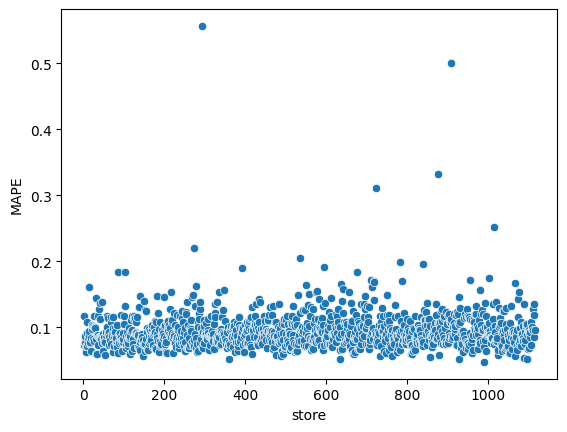

In [80]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. - Total Performance:
In this section, the code calculates the total performance metrics for all stores combined. It sums up the actual sales and predicted sales for all stores and then calculates the Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) for the total predictions.

In [81]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( '€{:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"€287,199,328.00"
1,worst_scenario,"€286,468,695.05"
2,best_scenario,"€287,929,958.37"


## 9.3. - Machine Learning Performance:
In this section, we are calculating machine learning performance.

In [82]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

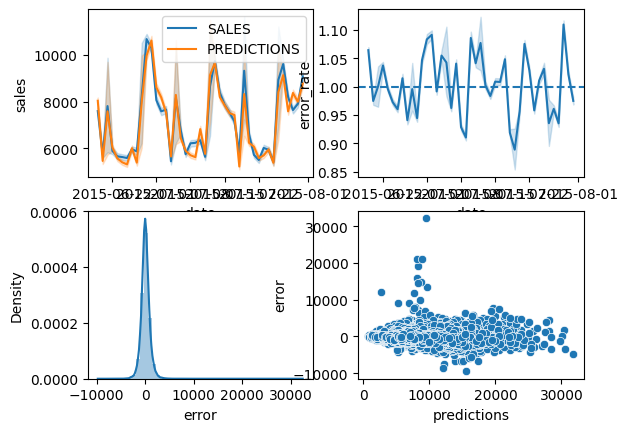

In [83]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'] )

# 10.0. STEP TEN - DEPLOY MODEL TO PRODUCTION
In this step, we will deploy the trained machine learning model to production so that it can be used for making predictions on new data. Deploying a model to production involves setting up a system or infrastructure that allows the model to receive input data, make predictions, and deliver the results to the end-users.

In [84]:
import pickle
# Salvar o modelo em um arquivo usando pickle
with open('model_xgb_tuned.pkl', 'wb') as file:
    pickle.dump(model_xgb_tuned, file)

## 10.1. - Implementing a Rossman class:
To implement the Rossman class, we'll follow the same structure provided above, but now we'll include the Flask app and the necessary methods to make predictions using the trained model. 

In [85]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:/Users/emers/Documents/repos/ds_producao/projeto_ds_producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load(   )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. - API Handler:
To implement the API Handler, we'll create a new Python script that will allow us to send test data to the API and receive the predictions. This script will simulate making requests to the API and receiving responses.

In [86]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann import Rossmann

# loading model
model = pickle.load(open('model_xgb_tuned.pkl', 'rb'))

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://10.102.37.150:5000
Press CTRL+C to quit


## 10.3. -  API Tester:
In this section, we are creating an API tester code to evaluate the performance of our deployed model. The API tester code sends test data to the API endpoint and retrieves the predictions returned by the model. 

In [ ]:
# loading test dataset
df10 = pd.read_csv( 'Data/test.csv' )

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 22, 24] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
# url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-model-prediction.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
data

'[{"Store": 20, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "d", "Assortment": "a", "CompetitionDistance": 2340.0, "CompetitionOpenSinceMonth": 5.0, "CompetitionOpenSinceYear": 2009.0, "Promo2": 1, "Promo2SinceWeek": 40.0, "Promo2SinceYear": 2014.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 24, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "c", "CompetitionDistance": 4590.0, "CompetitionOpenSinceMonth": 3.0, "CompetitionOpenSinceYear": 2000.0, "Promo2": 1, "Promo2SinceWeek

In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$302,309.45 in the next 6 weeks
Store Number 22 will sell R$210,937.31 in the next 6 weeks
Store Number 24 will sell R$223,260.60 in the next 6 weeks


In [ ]:
import requests
import pandas as pd

# Função para fazer previsões para uma loja específica
def make_prediction_for_store(store_number):
    # Carregar o conjunto de testes
    df10 = pd.read_csv('Data/test.csv')

    # Mesclar o conjunto de testes com as informações da loja
    df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

    # Escolher a loja específica para a previsão
    df_test = df_test[df_test['Store'] == store_number]

    # Remover dias fechados
    df_test = df_test[df_test['Open'] != 0]
    df_test = df_test[~df_test['Open'].isnull()]
    df_test = df_test.drop('Id', axis=1)

    # convert Dataframe to json
    data = json.dumps(df_test.to_dict(orient='records'))

    # API Call
    url = 'https://rossmann-model-prediction.onrender.com/rossmann/predict'
    header = {'Content-type': 'application/json'}
    response = requests.post(url, data=data, headers=header)

    # Verificar o resultado
    if response.status_code == 200:
        d1 = pd.DataFrame(response.json(), columns=response.json()[0].keys())
        d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
        for i in range(len(d2)):
            print('Store Number {} will sell €{:,.2f} in the next 6 weeks'.format(
                d2.loc[i, 'store'],
                d2.loc[i, 'prediction']
            ))
    else:
        print(f"Erro: Status code {response.status_code}")

# Chamar a função para fazer previsões para a loja 22
store_number = 22
make_prediction_for_store(store_number)


Store Number 22 will sell R$153,688.40 in the next 6 weeks
